In [6]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import Config
import datetime
import time
import copy
import BS

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, precision_score

from pymongo import MongoClient
client=MongoClient(Config.DB_Hostname,Config.DB_Port)

def _calc_option_price(S, K, T, r, future, vol_neg3, vol_neg2, vol_neg1, vol_0, vol_pos1, vol_pos2, vol_pos3, call = True):
    
    moneyness_percent = 100*(K/future - 1)
    
    if moneyness_percent <= -2:
        sigma = vol_neg2 + (vol_neg2 - vol_neg3) * (moneyness_percent + 2)
    
    elif moneyness_percent >= -2 and moneyness_percent <= -1:
        sigma = vol_neg1 + (vol_neg1 - vol_neg2) * (moneyness_percent + 1)

    elif moneyness_percent >= -1 and moneyness_percent <= 0:
        sigma = vol_0 + (vol_0 - vol_neg1) * (moneyness_percent)

    elif moneyness_percent >= 0 and moneyness_percent <= 1:
        sigma = vol_pos1 + (vol_pos1 - vol_0) * (moneyness_percent - 1)

    elif moneyness_percent >= 1 and moneyness_percent <= 2:
        sigma = vol_pos2 + (vol_pos2 - vol_pos1) * (moneyness_percent - 2)

    else:
        sigma = vol_pos3 + (vol_pos3 - vol_pos2) * (moneyness_percent - 3)
    
    if call:
        return BS.bs_call(S,K,T,r,sigma)

    else:
        return BS.bs_put(S,K,T,r,sigma)
    
    
def _calc_spread_return(spot, long_start, long_end, short_start, short_end, strike_spread):
    
    spread_benefit = short_start - long_start
    margin = spot*0.02 - spread_benefit
    brokerage = (long_start + long_end + short_start + short_end) * 0.001
    
    if spread_benefit > 0:
        margin += strike_spread
        
    if margin <0:
        print(f"Error_{margin}")
    
    return (long_end - long_start + short_start - short_end - brokerage)/margin


class Gap_Move_Classifier:
    
    def __init__(self, start_date, end_date, prediction_date, underlying, start_holding_period, end_holding_period):
        
        self.start_date = start_date #2017-01-01
        self.end_date = end_date #2017-01-01
        self.prediction_date = prediction_date #2017-01-01
        self.underlying = underlying #NIFTY, BANKNIFTY
        self.underlying_dynamics = None
        self.vol_surface = None
        self.days_to_expiry = None
        self.data_matrix = None
        self.return_matrix = None
        self.price_matrix = None
        self.performance_stats = None
        self.start_holding_period = start_holding_period #in minutes
        self.end_holding_period = end_holding_period #in minutes
        self.strike_range = [-1.5, -1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
        
        #start = time.time()
        self.underlying_dynamics = pd.DataFrame(client[f'{Config.Data_DB}'][f'{self.underlying}OHLC'].find())
        self.underlying_dynamics.drop(columns=['_id'],inplace=True)
        self.underlying_dynamics.sort_values(['date','batch_id'],inplace=True)
        self.underlying_dynamics=self.underlying_dynamics[(self.underlying_dynamics.date>=self.start_date)&(self.underlying_dynamics.date<=self.end_date)]
        self.underlying_dynamics.batch_id=self.underlying_dynamics.batch_id.astype(int)
        self.underlying_dynamics.set_index('date',inplace=True)
        #print(f"Prices Downloaded in {time.time() - start} seconds")

        #start=time.time()
        self.vol_surface=pd.DataFrame(client[f'{Config.Data_DB}']['Vol_Surface'].find({"SYMBOL" : self.underlying}))
        self.vol_surface=self.vol_surface[['vol_neg3', 'vol_neg2', 'vol_neg1', 'vol_0', 'vol_pos1', 'vol_pos2', 'vol_pos3', 'date']]
        self.vol_surface.sort_values('date',inplace=True)
        self.vol_surface=self.vol_surface[(self.vol_surface.date>=self.start_date)&(self.vol_surface.date<=self.end_date)]
        self.vol_surface.set_index('date',inplace=True)
        
        for col in self.vol_surface.columns:
            self.vol_surface[col] = np.where(self.vol_surface[col] < 0.02, np.nan, self.vol_surface[col])

        self.vol_surface.bfill(axis = 1, inplace = True)
        self.vol_surface.ffill(axis = 1, inplace = True)
        #print(f"Vol Surface Downloaded in {time.time() - start} seconds")
        
        #start=time.time()
        self.days_to_expiry = pd.DataFrame(client[f'{Config.Data_DB}']['Days_To_Expiry'].find({"underlying":self.underlying}))
        self.days_to_expiry.drop(columns = ['_id','underlying'],inplace=True)
        self.days_to_expiry.sort_values('date',inplace=True)
        self.days_to_expiry=self.days_to_expiry[(self.days_to_expiry.date>=self.start_date)&(self.days_to_expiry.date<=self.end_date)]
        self.days_to_expiry.set_index('date',inplace=True)
        #print(f"Expiry Dates Downloaded in {time.time()-start} seconds")

        #start=time.time()
        self._make_features()
        #print(f"Features Engineered in {time.time() - start} seconds")

        #start=time.time()
        self._generate_return_matrix()
        #print(f"Features Engineered in {time.time() - start} seconds")
                
    def _make_features(self):
        
        vol_surface = copy.deepcopy(self.vol_surface)
        if self.end_date not in vol_surface.index:
            vol_surface.loc[self.end_date] = [np.nan]*len(vol_surface.columns)

        closing_candle = self.underlying_dynamics[self.underlying_dynamics.batch_id==375 - (self.start_holding_period - 1)][['open']]
        if self.end_date not in closing_candle.index:
            closing_candle.loc[self.end_date] = np.nan
        closing_candle=closing_candle.shift()
        
        opening_candle = self.underlying_dynamics[self.underlying_dynamics.batch_id==1 + (self.end_holding_period - 1)][['close']]
        if self.end_date not in opening_candle.index:
            opening_candle.loc[self.end_date] = np.nan
        
        candle = pd.merge(closing_candle, opening_candle, left_index=True, right_index=True)
        candle.close = np.where(candle.close.isna(), candle.open, candle.close)
        
        self.data_matrix = pd.DataFrame()
        self.data_matrix["gap_move"] = (candle.close - candle.open) / candle.open
        self.data_matrix["gap_move_flag"] = np.where(self.data_matrix.gap_move>=0, 1, 0)
        self.data_matrix = pd.merge(self.data_matrix, vol_surface.shift(), left_index = True, right_index = True).dropna()
        
        candle = pd.merge(candle, vol_surface.shift(), left_index=True, right_index=True)        
        candle = pd.merge(candle, self.days_to_expiry, left_index=True, right_index=True)
        candle = pd.merge(candle , 
                          self.days_to_expiry.shift().rename(columns = 
                            {"current_week" : "current_week_yesterday", "next_week": "next_week_yesterday"}), 
                          left_index=True,
                          right_index=True)
        
        candle.current_week_yesterday = np.where(candle.current_week_yesterday == 1, candle.next_week_yesterday, candle.current_week_yesterday)
        
        candle["entry_time"] = (candle.current_week_yesterday - 1 + self.start_holding_period/1440) / 365
        candle["exit_time"] = (candle.current_week - 0.75 - self.end_holding_period/1440) / 365
        candle["future_open"] = candle.open * np.exp(Config.interest_rate * candle.entry_time)
        candle["future_close"] = candle.close * np.exp(Config.interest_rate * candle.exit_time)
        candle.dropna(inplace = True)
        
        for strike_range in self.strike_range:
            
            candle[f"{strike_range}_strike_call_and_put"] = candle.open * (1 + strike_range/100) * np.exp(Config.interest_rate * (candle.current_week_yesterday - 1 + self.start_holding_period/1440) / 365)
            
            candle[f"call_{strike_range}_yesterday"] = candle.apply(lambda x : _calc_option_price(x.open, 
                                                                                                  x[f"{strike_range}_strike_call_and_put"], 
                                                                                                  x["entry_time"], 
                                                                                                  Config.interest_rate, 
                                                                                                  x["future_open"], 
                                                                                                  x["vol_neg3"], 
                                                                                                  x["vol_neg2"], 
                                                                                                  x["vol_neg1"], 
                                                                                                  x["vol_0"], 
                                                                                                  x["vol_pos1"], 
                                                                                                  x["vol_pos2"],
                                                                                                  x["vol_pos3"], 
                                                                                                  call = True), axis = 1)
            
            candle[f"call_{strike_range}_today"] = candle.apply(lambda x : _calc_option_price(x.close, 
                                                                                              x[f"{strike_range}_strike_call_and_put"],
                                                                                              x["exit_time"],
                                                                                              Config.interest_rate,
                                                                                              x["future_close"], 
                                                                                              x["vol_neg3"], 
                                                                                              x["vol_neg2"], 
                                                                                              x["vol_neg1"], 
                                                                                              x["vol_0"], 
                                                                                              x["vol_pos1"], 
                                                                                              x["vol_pos2"],
                                                                                              x["vol_pos3"], 
                                                                                              call = True), axis = 1)

            candle[f"put_{strike_range}_yesterday"] = candle.apply(lambda x : _calc_option_price(x.open, 
                                                                                                 x[f"{strike_range}_strike_call_and_put"],
                                                                                                 x["entry_time"],
                                                                                                 Config.interest_rate,
                                                                                                 x["future_open"], 
                                                                                                 x["vol_neg3"], 
                                                                                                 x["vol_neg2"], 
                                                                                                 x["vol_neg1"], 
                                                                                                 x["vol_0"], 
                                                                                                 x["vol_pos1"], 
                                                                                                 x["vol_pos2"],
                                                                                                 x["vol_pos3"], 
                                                                                                 call = False), axis = 1)
            
            candle[f"put_{strike_range}_today"] = candle.apply(lambda x : _calc_option_price(x.close, 
                                                                                              x[f"{strike_range}_strike_call_and_put"],
                                                                                              x["exit_time"],
                                                                                              Config.interest_rate,
                                                                                              x["future_close"], 
                                                                                              x["vol_neg3"], 
                                                                                              x["vol_neg2"], 
                                                                                              x["vol_neg1"], 
                                                                                              x["vol_0"], 
                                                                                              x["vol_pos1"], 
                                                                                              x["vol_pos2"],
                                                                                              x["vol_pos3"], 
                                                                                              call = False), axis = 1)
                            
        self.price_matrix = candle[(candle.columns[candle.columns.str.contains('call')])| (candle.columns[candle.columns.str.contains('put')]) ]
        self.price_matrix["open"] = candle[['open']]
        self.price_matrix["current_week_yesterday"] = candle[['current_week_yesterday']]
        
    def _generate_return_matrix(self):
        
        self.return_matrix = pd.DataFrame({"date":sorted(self.price_matrix.index)}).set_index('date')
        for index, strike_range_lower in enumerate(self.strike_range[:-1]):
            for strike_range_upper in self.strike_range[index+1:]:

                call_long_yesterday = f"call_{strike_range_lower}_yesterday"
                call_long_today = f"call_{strike_range_lower}_today"
                call_short_yesterday = f"call_{strike_range_upper}_yesterday"
                call_short_today = f"call_{strike_range_upper}_today"
                call_short_strike = f"{strike_range_upper}_strike_call_and_put"
                call_long_strike = f"{strike_range_lower}_strike_call_and_put"
                
                put_long_yesterday = f"put_{strike_range_lower}_yesterday"
                put_long_today = f"put_{strike_range_lower}_today"
                put_short_yesterday = f"put_{strike_range_upper}_yesterday"
                put_short_today = f"put_{strike_range_upper}_today"
                put_short_strike = f"{strike_range_upper}_strike_call_and_put"
                put_long_strike = f"{strike_range_lower}_strike_call_and_put"
                
                if strike_range_lower<=0.75:
                    self.return_matrix[f"call_{strike_range_lower}_{strike_range_upper}"] = self.price_matrix.apply(lambda x: _calc_spread_return(x['open'],
                                                                                        x[call_long_yesterday], 
                                                                                        x[call_long_today], 
                                                                                        x[call_short_yesterday],
                                                                                        x[call_short_today], 
                                                                                        x[call_short_strike] - x[call_long_strike]),
                                                                                        axis=1)
                if strike_range_lower>=-0.75:
                    self.return_matrix[f"put_{strike_range_lower}_{strike_range_upper}"] = self.price_matrix.apply(lambda x: _calc_spread_return(x['open'], 
                                                                                         x[put_long_yesterday], 
                                                                                         x[put_long_today],
                                                                                         x[put_short_yesterday],
                                                                                         x[put_short_today],  
                                                                                         x[put_short_strike] - x[put_long_strike]),
                                                                                         axis=1)
        
    def _generate_performance_stats(self, 
                                    tail = None, 
                                    return_matrix_user = None, 
                                    start_holding_period = None, 
                                    end_holding_period = None):
        
        if start_holding_period is not None:
            self.start_holding_period = start_holding_period
        
        if end_holding_period is not None:
            self.end_holding_period = end_holding_period
            
        if return_matrix_user is not None:
            self.return_matrix = return_matrix_user[return_matrix_user.columns[(return_matrix_user.columns.str.contains('call')) | (return_matrix_user.columns.str.contains('put'))]]

        sim = pd.DataFrame(index = self.return_matrix.columns)
        
        if tail is not None:
            self.return_matrix = self.return_matrix.tail(tail)        
        return_matrix = self.return_matrix.copy()
        
        sim["Sharpe"] = 16 * return_matrix.mean()/return_matrix.std()

        rolling_cumulative = (1 + return_matrix).rolling(60).apply(lambda x : x.prod()).dropna()
        sim["60_Day_Median_Cumulative_Return"] = rolling_cumulative.median()
        sim["60_Day_Mean_Cumulative_Return"] = rolling_cumulative.mean()
        sim["60_Day_Max_Cumulative_Return"] = rolling_cumulative.max()
        sim["60_Day_Min_Cumulative_Return"] = rolling_cumulative.min()

        rolling_cumulative = (1 + return_matrix).rolling(250).apply(lambda x : x.prod()).dropna()
        sim["250_Day_Median_Cumulative_Return"] = rolling_cumulative.median()
        sim["250_Day_Mean_Cumulative_Return"] = rolling_cumulative.mean()
        sim["250_Day_Max_Cumulative_Return"] = rolling_cumulative.max()
        sim["250_Day_Min_Cumulative_Return"] = rolling_cumulative.min()

        sim["Return"] = ((1 + return_matrix).cumprod().tail(1) ** (1/len(return_matrix)) - 1).mean()

        sim["Last_60_Day_Cumulative_Return"] = (1 + return_matrix).tail(60).cumprod().tail(1).mean()
        sim["Last_250_Day_Cumulative_Return"] = (1 + return_matrix).tail(250).cumprod().tail(1).mean()
        sim["MDD"] = (((1 + return_matrix).cumprod() / ((1 + return_matrix).cumprod().cummax())) - 1).min()   
        
        sim["start_holding_period"] = self.start_holding_period
        sim["end_holding_period"] = self.end_holding_period
        
        self.performance_stats = sim.copy()

In [7]:
start_date = '2015-01-09' #starting data point best left untouchedd
end_date = '2024-02-20'#'2022-01-03'#'2023-07-03' # Last day for which you want prediction - should be next trading day
prediction_date = '2024-01-23' # should be legitimate and after start date and before end date. Only dates >= are processed and pushed into DB
underlying = 'NIFTY' #NIFTY/BANKNIFTY
start_holding_period = 13
end_holding_period = 13
self = Gap_Move_Classifier(start_date, end_date, prediction_date, underlying, start_holding_period, end_holding_period)
self._generate_performance_stats()

In [8]:
self.return_matrix["call_-1.5_1.5"]

date
2015-01-13    0.02622
2015-01-14    0.00476
2015-01-15    0.38888
2015-01-19    0.07252
2015-01-20    0.05773
               ...   
2024-02-14   -0.25010
2024-02-15    0.07481
2024-02-16    0.05627
2024-02-19    0.01172
2024-02-20   -0.05576
Name: call_-1.5_1.5, Length: 2245, dtype: float64

In [2]:
start_holding_period = list(range(1,16))
end_holding_period = list(range(1,16))
tail = None
return_summary = []
summary = []
for start in start_holding_period:
    for end in end_holding_period:
        
        print(start,end)
        
        start_date = '2015-01-09' #starting data point best left untouchedd
        end_date = '2024-02-15'#'2022-01-03'#'2023-07-03' # Last day for which you want prediction - should be next trading day
        prediction_date = '2024-01-19' # should be legitimate and after start date and before end date. Only dates >= are processed and pushed into DB
        underlying = 'NIFTY' #NIFTY/BANKNIFTY
        self = Gap_Move_Classifier(start_date, end_date, prediction_date, underlying, start, end)
        self._generate_performance_stats(tail=tail)
        summary.append(self.performance_stats)
        
        temp = pd.merge(self.return_matrix, self.days_to_expiry[['current_week']], left_index = True, right_index = True)
        temp["start_holding_period"] = start
        temp["end_holding_period"] = end
        return_summary.append(temp)
        
summary = pd.concat(summary)
return_summary = pd.concat(return_summary)

1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
12 13
12 14
12 15
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
13 14
13 15
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
14 15
1

In [3]:
return_summary.current_week = np.where(return_summary.current_week == 5, 4, return_summary.current_week)
return_summary.current_week = np.where(return_summary.current_week == 6, 7, return_summary.current_week)
selected_strategies = []
for current_week in sorted(return_summary.current_week.unique()):
    
    print(current_week)
    temp = []
    for start in sorted(return_summary.start_holding_period.unique()):
        for end in sorted(return_summary.end_holding_period.unique()):
            
            self._generate_performance_stats(return_matrix_user = return_summary[(return_summary.current_week == current_week) & (return_summary.start_holding_period == start) & (return_summary.end_holding_period == end)], 
                                   start_holding_period = start, end_holding_period = end)
            temp.append(self.performance_stats)
    
    temp = pd.concat(temp)
    temp["current_week"] = current_week
    selected_strategies.append(temp.sort_values('Return', ascending=False).head(1))
selected_strategies = pd.concat(selected_strategies)
selected_strategies

1
2
3
4
7


,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period,current_week
call_-1.5_0.25,4.10581,3.32121,4.12093,11.55913,0.66039,108.59977,151.55430,791.07942,15.67636,0.01990,1.40893,22.22758,-0.63758,1,9,1
call_-1.5_-0.25,4.35012,2.19483,2.15243,4.39633,0.58040,36.36417,34.75499,69.71272,8.21331,0.01109,1.12147,20.57481,-0.46599,13,15,2
call_-1.5_1.5,3.26153,2.33723,5.39087,48.43864,0.18107,58.50712,69.63407,536.83284,1.10559,0.01444,2.78603,536.83284,-0.83955,13,13,3
call_-1.5_-1,5.48017,1.67295,1.60786,2.32425,0.94670,5.97338,6.39801,10.29872,4.44786,0.00779,2.32425,5.84472,-0.30432,9,1,4
put_1_1.5,4.56301,1.59196,1.66608,2.60775,1.09135,8.38056,8.50287,12.43554,6.58546,0.00918,2.13164,10.24134,-0.24749,13,12,7


In [30]:
selected_return_matrix = []
for strategy, start, end, current_week in zip(selected_strategies.index, 
                                              selected_strategies.start_holding_period, 
                                              selected_strategies.end_holding_period, 
                                              selected_strategies.current_week):
    selected_return_matrix.append(return_summary[(return_summary.start_holding_period == start) & 
                   (return_summary.end_holding_period == end) & 
                   (return_summary.current_week == current_week)][[strategy]].rename(columns = {strategy : "strategy_call_and_put"}))

selected_return_matrix = pd.concat(selected_return_matrix).sort_index()
self._generate_performance_stats(return_matrix_user=selected_return_matrix)
self.performance_stats

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
strategy_call_and_put,3.56807,2.50024,2.55216,10.88652,0.15046,21.14575,56.77365,536.07476,1.89038,0.01261,2.81991,32.35975,-0.85537,15,15


In [5]:
for lag in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250]:
    print(((1+selected_return_matrix.head(lag).tail(250)).cumprod()**(1/250)).tail(1))

            strategy_call_and_put
date                             
2016-01-18                1.00906
            strategy_call_and_put
date                             
2017-01-23                1.01207
            strategy_call_and_put
date                             
2018-01-25                1.02001
            strategy_call_and_put
date                             
2019-02-01                1.00471
            strategy_call_and_put
date                             
2020-02-10                1.01481
            strategy_call_and_put
date                             
2021-02-11                1.01261
            strategy_call_and_put
date                             
2022-02-17                1.02078
            strategy_call_and_put
date                             
2023-02-21                1.00579
            strategy_call_and_put
date                             
2024-02-15                1.01400


In [27]:
temp = return_summary.drop(columns = ["current_week", "start_holding_period", "end_holding_period"]).max(axis=1).groupby('date').max()

In [29]:
(1+temp).cumprod()**(1/2242)

date
2015-01-13   1.00004
2015-01-14   1.00005
2015-01-15   1.00023
2015-01-19   1.00030
2015-01-20   1.00033
               ...  
2024-02-09   1.07442
2024-02-12   1.07443
2024-02-13   1.07447
2024-02-14   1.07447
2024-02-15   1.07453
Length: 2242, dtype: float64

In [8]:
selected_return_matrix.describe()

,strategy_call_and_put
count,2242.00000
mean,0.01505
std,0.06747
min,-0.42983
25%,-0.01073
50%,0.01707
75%,0.04776
max,0.25454


<Axes: xlabel='date'>

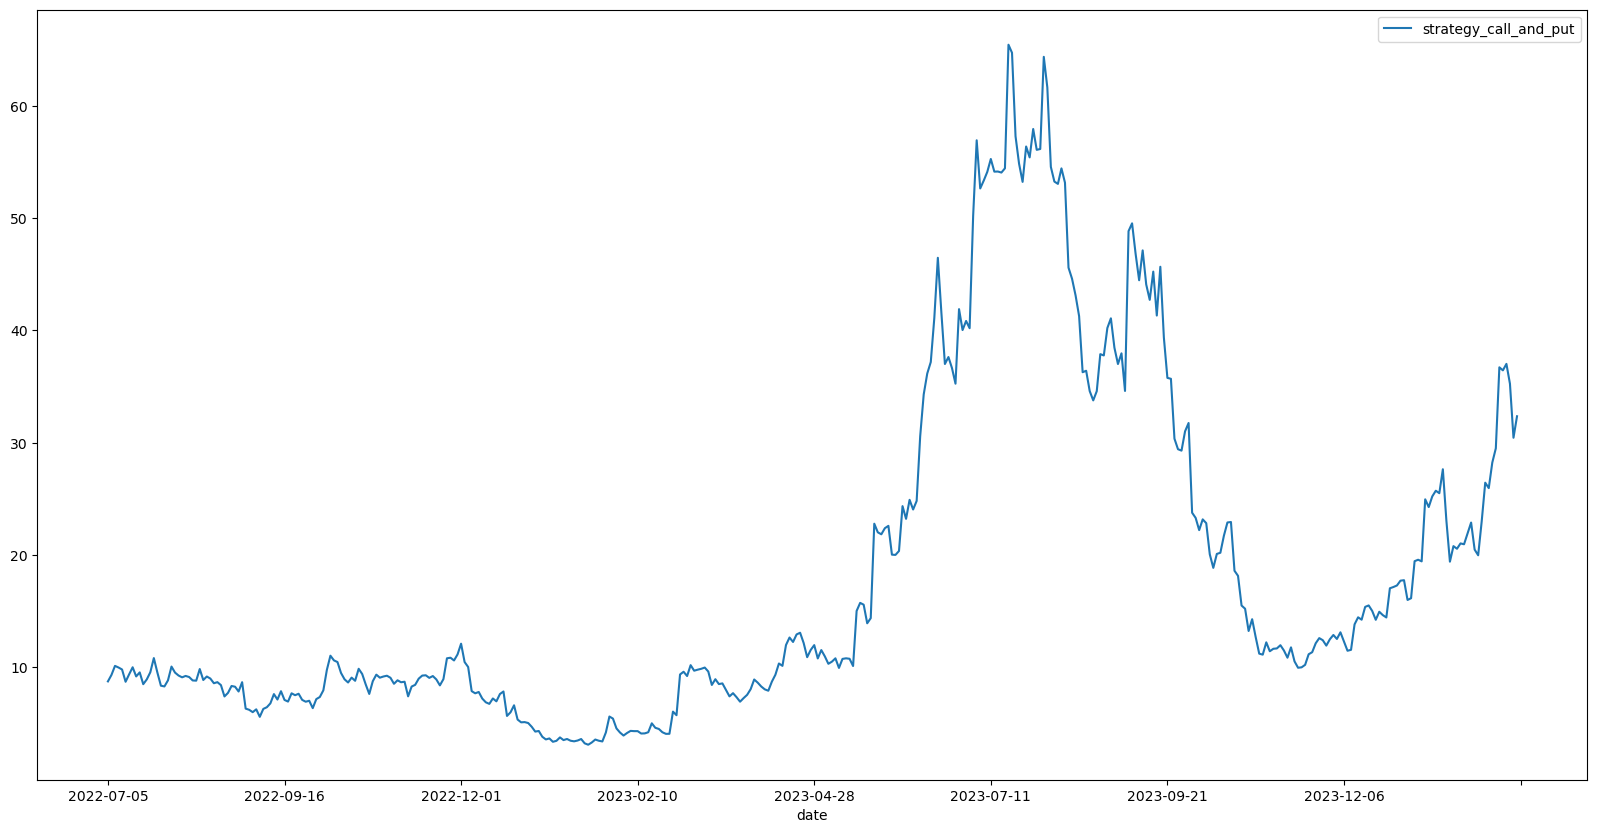

In [9]:
(1+selected_return_matrix).rolling(250).apply(lambda x: x.prod()).tail(400).plot(figsize=(20,10))

In [10]:
selected_return_matrix = []
for strategy, start, end, current_week in zip(['call_-1.25_0', 'call_-1.5_0.25', 'call_-1.5_0.75', 'call_-1.5_-0.25',
       'call_-1.5_1.5'], [1, 9, 9, 9, 9], [1, 13, 1, 1, 10], [1, 2, 3, 4, 7]):
    selected_return_matrix.append(return_summary[(return_summary.start_holding_period == start) & 
                   (return_summary.end_holding_period == end) & 
                   (return_summary.current_week == current_week)][[strategy]].rename(columns = {strategy : "strategy_call_and_put"}))

selected_return_matrix = pd.concat(selected_return_matrix).sort_index()
self._generate_performance_stats(return_matrix_user=selected_return_matrix)
self.performance_stats

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
strategy_call_and_put,2.04013,1.66744,1.87987,6.01135,0.02810,4.67025,9.75590,94.23606,0.10569,0.00645,3.56258,20.03846,-0.97513,15,15


In [11]:
for lag in [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2228]:
    print(((1+selected_return_matrix.head(lag).tail(250)).cumprod()**(1/250)).tail(1))

            strategy_call_and_put
date                             
2016-01-18                1.00406
            strategy_call_and_put
date                             
2017-01-23                1.00413
            strategy_call_and_put
date                             
2018-01-25                1.01817
            strategy_call_and_put
date                             
2019-02-01                1.00143
            strategy_call_and_put
date                             
2020-02-10                1.00814
            strategy_call_and_put
date                             
2021-02-11                1.00315
            strategy_call_and_put
date                             
2022-02-17                1.00664
            strategy_call_and_put
date                             
2023-02-21                1.00025
            strategy_call_and_put
date                             
2024-01-25                1.01048


In [12]:
selected_return_matrix.describe()

,strategy_call_and_put
count,2242.00000
mean,0.00946
std,0.07420
min,-0.44432
25%,-0.01917
50%,0.02219
75%,0.05752
max,0.24254


In [31]:
temp = summary.copy()
for metric in ['Sharpe', 'MDD', '250_Day_Median_Cumulative_Return', '60_Day_Median_Cumulative_Return',
               'Return', 'Last_250_Day_Cumulative_Return', 'Last_60_Day_Cumulative_Return']:
    temp = temp[temp[metric]>=temp[metric].quantile(0.7)]
    
temp

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.5,3.01122,1.66812,1.61200,3.48109,0.14636,6.14510,6.72430,23.79334,0.68831,0.00674,2.54741,9.06326,-0.85677,1,10
call_-1.5_-0.5,2.87134,1.63086,1.58148,3.46478,0.15511,5.73882,6.22792,22.94036,0.79753,0.00646,2.48546,9.30588,-0.84915,9,8
call_-1.5_-0.5,2.92743,1.64919,1.59500,3.67974,0.15345,5.88919,6.39435,22.46268,0.79486,0.00659,2.52368,9.61575,-0.85103,9,9
call_-1.5_-0.5,2.97119,1.66625,1.60945,3.76365,0.14528,6.19163,6.63057,23.07345,0.71108,0.00668,2.55861,10.30350,-0.85767,9,10
call_-1.5_-0.5,2.92986,1.67144,1.60460,4.08795,0.12309,5.74795,6.43898,22.49959,0.62104,0.00654,2.48626,9.82550,-0.88039,9,14
call_-1.5_-0.5,2.92795,1.64752,1.61039,3.99650,0.14327,5.68644,6.67645,25.12580,0.73274,0.00662,2.53211,8.45299,-0.85940,14,10


In [32]:
summary.sort_values("Sharpe", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-1,5.18354,1.51824,1.49115,2.24286,0.44260,4.80782,5.15393,12.14021,1.57395,0.00640,2.19262,7.12824,-0.62848,1,13
call_-1.5_-1,5.17766,1.52537,1.50026,2.30281,0.45723,4.90544,5.25003,12.45917,1.60536,0.00649,2.21822,7.43860,-0.62198,13,13
call_-1.5_-1,5.17197,1.51709,1.48867,2.25350,0.43793,4.80942,5.11083,11.74262,1.59427,0.00637,2.21867,7.20524,-0.62148,1,14
call_-1.5_-1,5.16287,1.52084,1.49542,2.26430,0.44859,4.71860,5.22431,14.97990,1.59323,0.00642,2.18753,7.20224,-0.62923,8,13
call_-1.5_-1,5.16112,1.52198,1.49793,2.31406,0.44564,4.89883,5.20979,12.09610,1.62073,0.00647,2.24610,7.55443,-0.61856,13,14


In [33]:
summary.sort_values("MDD", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-1.25,2.15515,1.10409,1.08662,1.37264,0.60910,1.35536,1.39706,2.34800,0.83330,0.00137,1.35250,1.81834,-0.40576,13,4
call_-1.5_-1.25,2.26116,1.10464,1.08882,1.37098,0.60931,1.36370,1.41011,2.34052,0.83163,0.00140,1.34844,1.80819,-0.40592,13,3
call_-1.5_-1.25,2.11916,1.10302,1.08507,1.37166,0.60453,1.36427,1.39008,2.31381,0.82281,0.00134,1.35330,1.79553,-0.40607,14,4
call_-1.5_-1.25,2.22309,1.10335,1.08713,1.36843,0.60402,1.36594,1.40262,2.29716,0.81927,0.00138,1.34792,1.78209,-0.40630,14,3
call_-1.5_-1.25,2.18226,1.09951,1.08550,1.37544,0.60406,1.33921,1.39418,2.28921,0.81457,0.00135,1.35491,1.79574,-0.40645,15,3


In [34]:
summary.sort_values("60_Day_Median_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.25,2.45920,1.70598,1.68593,4.52205,0.06682,5.46137,8.03962,45.47322,0.28487,0.00647,2.48296,8.45054,-0.93500,1,13
call_-1.5_-0.25,2.50217,1.70004,1.69153,4.33365,0.07633,5.75317,8.25088,47.14793,0.34294,0.00662,2.64031,9.53404,-0.92562,1,10
call_-1.5_-0.25,2.44542,1.69948,1.68401,4.16664,0.06943,5.61074,8.24670,48.48097,0.29097,0.00645,2.40130,7.94329,-0.93249,1,12
call_-1.5_-0.25,2.42569,1.69802,1.67859,4.73372,0.06930,5.20360,7.91639,45.98804,0.30086,0.00637,2.52003,8.17896,-0.93306,1,14
call_-1.5_-0.25,2.39393,1.69445,1.69221,5.89379,0.06918,4.81561,8.01741,47.48681,0.40843,0.00632,2.42832,7.38528,-0.93373,13,14


In [35]:
summary.sort_values("60_Day_Mean_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_0.25,1.61213,1.50535,1.75819,8.74770,0.02025,2.44461,8.98798,88.95372,0.08458,0.00447,2.80782,4.56882,-0.98052,13,10
call_-1.5_0.25,1.65811,1.50399,1.75365,7.11353,0.02011,2.88857,9.38875,90.28639,0.05765,0.00467,2.97194,5.45547,-0.98071,1,10
call_-1.5_0.25,1.56881,1.46450,1.74844,9.35881,0.01967,2.19593,9.06528,102.48657,0.07774,0.00427,2.62087,3.48964,-0.98113,13,13
call_-1.5_0.25,1.54321,1.42749,1.74723,9.67174,0.02215,2.31658,9.88002,87.55378,0.06492,0.00414,2.76129,4.03426,-0.97867,8,10
call_-1.5_0.25,1.54068,1.47695,1.74694,9.95386,0.02045,2.13394,9.06700,103.62930,0.08372,0.00414,2.73190,3.30808,-0.98054,13,14


In [36]:
summary.sort_values("60_Day_Max_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,0.61566,0.95771,1.71195,20.55613,0.00358,0.35580,13.59153,429.97922,0.00219,-0.00253,3.00295,1.44719,-0.99994,8,14
call_-1.5_1.5,0.57427,0.95918,1.67829,19.31850,0.00365,0.31425,13.39261,424.14976,0.00151,-0.00287,2.75045,1.32310,-0.99994,8,15
call_-1.5_1.25,0.57221,0.96328,1.64366,19.01160,0.00401,0.36630,9.36902,265.72878,0.00253,-0.00247,2.83337,1.29981,-0.99989,8,14
call_-1.5_1.5,0.64580,0.97740,1.69294,18.44973,0.00343,0.37769,13.15755,388.20755,0.00173,-0.00230,2.88729,1.54373,-0.99992,8,13
call_-1.25_1.5,0.27183,0.79283,1.49316,17.97493,0.00382,0.18560,7.06977,214.87377,0.00132,-0.00512,2.40659,0.66214,-1.00000,8,14


In [37]:
summary.sort_values("60_Day_Min_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
put_1_1.25,-0.15379,0.95661,0.98868,1.48554,0.68266,0.79203,0.99908,2.76589,0.53859,-0.00031,1.17011,1.51839,-0.87231,12,3
put_1_1.25,-0.05426,0.96598,0.99505,1.47198,0.68232,0.82973,1.02049,2.73525,0.52781,-0.00020,1.17874,1.54267,-0.84056,13,3
put_1_1.25,-0.38228,0.94628,0.97665,1.45449,0.68038,0.76978,0.95926,2.64260,0.45406,-0.00054,1.09871,1.36555,-0.90827,4,3
put_1_1.25,-0.30385,0.95214,0.98005,1.47741,0.67974,0.78367,0.96283,2.58251,0.49845,-0.00046,1.10585,1.41548,-0.89440,5,4
put_1_1.25,-0.38426,0.94911,0.97617,1.44201,0.67899,0.78072,0.95445,2.52294,0.46317,-0.00054,1.08555,1.31600,-0.90246,3,3


In [38]:
summary.sort_values("250_Day_Median_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.5,2.97119,1.66625,1.60945,3.76365,0.14528,6.19163,6.63057,23.07345,0.71108,0.00668,2.55861,10.30350,-0.85767,9,10
call_-1.5_-0.5,3.01122,1.66812,1.61200,3.48109,0.14636,6.14510,6.72430,23.79334,0.68831,0.00674,2.54741,9.06326,-0.85677,1,10
call_-1.5_-0.5,2.93590,1.65777,1.60499,3.66793,0.13323,6.02139,6.59135,23.18986,0.64427,0.00658,2.36933,9.16968,-0.86923,9,12
call_-1.5_-0.5,2.95849,1.66437,1.60913,3.92553,0.12174,5.98552,6.53795,22.15182,0.60929,0.00661,2.43434,9.78922,-0.88056,9,13
call_-1.5_-0.5,2.99584,1.67920,1.61238,3.61779,0.12142,5.96619,6.64585,23.25626,0.58015,0.00666,2.40939,8.60921,-0.88105,1,13


In [39]:
summary.sort_values("250_Day_Mean_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,0.66561,0.97638,1.69746,17.26608,0.00351,0.44872,14.46457,417.63715,0.00264,-0.00215,3.09206,1.88851,-0.99990,8,10
call_-1.5_1.5,0.61566,0.95771,1.71195,20.55613,0.00358,0.35580,13.59153,429.97922,0.00219,-0.00253,3.00295,1.44719,-0.99994,8,14
call_-1.5_1.5,0.57427,0.95918,1.67829,19.31850,0.00365,0.31425,13.39261,424.14976,0.00151,-0.00287,2.75045,1.32310,-0.99994,8,15
call_-1.5_1.5,0.64580,0.97740,1.69294,18.44973,0.00343,0.37769,13.15755,388.20755,0.00173,-0.00230,2.88729,1.54373,-0.99992,8,13
call_-1.5_1.5,0.63928,0.96377,1.65327,16.55356,0.00385,0.44713,12.95680,375.04263,0.00327,-0.00234,2.94032,1.33323,-0.99988,8,9


In [40]:
summary.sort_values("250_Day_Max_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,0.61566,0.95771,1.71195,20.55613,0.00358,0.35580,13.59153,429.97922,0.00219,-0.00253,3.00295,1.44719,-0.99994,8,14
call_-1.5_1.5,0.57427,0.95918,1.67829,19.31850,0.00365,0.31425,13.39261,424.14976,0.00151,-0.00287,2.75045,1.32310,-0.99994,8,15
call_-1.5_1.5,0.66561,0.97638,1.69746,17.26608,0.00351,0.44872,14.46457,417.63715,0.00264,-0.00215,3.09206,1.88851,-0.99990,8,10
call_-1.5_1.5,0.64580,0.97740,1.69294,18.44973,0.00343,0.37769,13.15755,388.20755,0.00173,-0.00230,2.88729,1.54373,-0.99992,8,13
call_-1.5_1.5,0.63928,0.96377,1.65327,16.55356,0.00385,0.44713,12.95680,375.04263,0.00327,-0.00234,2.94032,1.33323,-0.99988,8,9


In [41]:
summary.sort_values("250_Day_Min_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-1,4.85968,1.48551,1.46169,2.24552,0.47470,4.29741,4.70842,11.40425,1.71517,0.00606,1.93312,6.51005,-0.61715,13,1
call_-1.5_-1,5.06542,1.51432,1.48651,2.28340,0.43555,4.72747,5.04379,11.67497,1.67910,0.00634,2.22478,7.40033,-0.62476,11,14
call_-1.5_-1,5.04076,1.50606,1.48550,2.28609,0.44571,4.75108,5.04708,11.68366,1.67138,0.00632,2.22781,7.29102,-0.61296,15,14
call_-1.5_-1,4.79984,1.47601,1.45504,2.25647,0.47249,4.13599,4.62075,11.12869,1.66917,0.00599,1.90102,6.30441,-0.61859,12,1
call_-1.5_-1,4.78281,1.47659,1.44885,2.22210,0.46788,4.04106,4.55688,11.02693,1.66800,0.00592,1.88646,6.22574,-0.61895,7,1


In [42]:
summary.sort_values("Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.5,2.99542,1.66833,1.62672,4.11326,0.14646,5.87196,6.91323,24.81686,0.77810,0.00677,2.47369,8.84172,-0.85618,13,10
call_-1.5_-0.5,3.01122,1.66812,1.61200,3.48109,0.14636,6.14510,6.72430,23.79334,0.68831,0.00674,2.54741,9.06326,-0.85677,1,10
call_-1.5_-0.5,2.98889,1.67508,1.62809,4.31498,0.12487,5.94953,6.83356,24.44636,0.72940,0.00672,2.34602,8.38867,-0.87767,13,13
call_-1.5_-0.5,2.97119,1.66625,1.60945,3.76365,0.14528,6.19163,6.63057,23.07345,0.71108,0.00668,2.55861,10.30350,-0.85767,9,10
call_-1.5_-0.5,2.96014,1.67326,1.62310,4.04587,0.13205,5.96177,6.87928,25.41189,0.74117,0.00668,2.28134,7.87340,-0.87055,13,12


In [25]:
summary.sort_values("Last_60_Day_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_1.5,0.68246,1.05898,1.53310,12.01411,0.00323,0.58149,5.35368,122.55002,0.00282,-0.00202,3.99319,4.44667,-0.99986,9,10
call_-1.5_1.5,0.63281,1.04120,1.54053,14.34770,0.00328,0.42621,5.18825,120.44812,0.00232,-0.00241,3.87672,3.41143,-0.99992,9,14
call_-1.5_1.5,0.65704,1.01696,1.49726,11.52346,0.00354,0.53216,4.90486,108.88769,0.00349,-0.00221,3.79973,3.14295,-0.99984,9,9
call_-1.5_1.25,0.63947,1.04715,1.48973,11.34616,0.00364,0.56631,4.13532,78.90090,0.00324,-0.00198,3.75016,3.82333,-0.99975,9,10
call_-1.5_1.5,0.66310,1.04921,1.52966,12.85304,0.00316,0.44630,5.08326,108.23767,0.00184,-0.00218,3.72603,3.63625,-0.99989,9,13


In [26]:
summary.sort_values("Last_250_Day_Cumulative_Return", ascending=False).head(5)

,Sharpe,60_Day_Median_Cumulative_Return,60_Day_Mean_Cumulative_Return,60_Day_Max_Cumulative_Return,60_Day_Min_Cumulative_Return,250_Day_Median_Cumulative_Return,250_Day_Mean_Cumulative_Return,250_Day_Max_Cumulative_Return,250_Day_Min_Cumulative_Return,Return,Last_60_Day_Cumulative_Return,Last_250_Day_Cumulative_Return,MDD,start_holding_period,end_holding_period
call_-1.5_-0.25,2.36565,1.64674,1.64185,4.40213,0.09450,5.32738,7.16669,40.09559,0.37160,0.00620,2.54072,11.00444,-0.91400,9,5
call_-1.5_-0.25,2.44747,1.68354,1.67918,4.79943,0.07758,5.75155,7.83500,42.95077,0.37501,0.00647,2.67490,10.87554,-0.92421,9,10
call_-1.5_-0.5,2.97119,1.66625,1.60945,3.76365,0.14528,6.19163,6.63057,23.07345,0.71108,0.00668,2.55861,10.30350,-0.85767,9,10
call_-1.5_-0.25,2.33805,1.64104,1.62374,4.47682,0.09533,4.91366,6.91663,35.86719,0.35031,0.00609,2.46583,10.29342,-0.91204,9,4
call_-1.5_-0.5,2.84699,1.64173,1.57563,3.50691,0.16535,5.55520,6.09370,21.78681,0.68599,0.00636,2.38905,10.28158,-0.84629,9,5


In [ ]:
# summary.to_csv('Nifty_Full.csv')

In [ ]:
return_summary.to_csv('Nifty_Full_Sim.csv')

In [ ]:
(1 + self.return_matrix["call_-1_0.75"]).rolling(250).apply(lambda x: x.prod()).dropna().quantile(0.0025)

In [ ]:
27357.49229**(1/1000)

In [ ]:
import numpy as np
future = 21393
future*=np.exp(0.07*14/248)

In [ ]:
future*0.99

In [ ]:
future*1.005